In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
# import tensorflow_io as tfio
import numpy as np
import pandas as pd
from scipy import signal

In [2]:
tf.__version__

'2.9.1'

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

IMAGE_SIZE = (128, 128)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

data_spec = r"./data/output/"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_spec, 'train'),
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_spec, 'val'),
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_spec, 'test'),
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/all/',
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

b_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_spec, 'test_black_screen'),
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 1379 files belonging to 2 classes.
Found 171 files belonging to 2 classes.
Found 173 files belonging to 2 classes.
Found 1854 files belonging to 2 classes.
Found 17 files belonging to 2 classes.


In [51]:
print('Train Class Distribution: ')
print('Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'train', 'cacao')))))
print('Non-Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'train', 'non_cacao')))))

print('Test Class Distribution: ')
print('Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'test', 'cacao')))))
print('Non-Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'test', 'non_cacao')))))

print('Val Class Distribution: ')
print('Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'val', 'cacao')))))
print('Non-Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'val', 'non_cacao')))))

print('B_Test Distribution: ')
print('Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'test_black_screen', 'cacao')))))
print('Non-Cacao: {}'.format(len(os.listdir(os.path.join(data_spec, 'test_black_screen', 'non_cacao')))))

Train Class Distribution: 
Cacao: 579
Non-Cacao: 800
Test Class Distribution: 
Cacao: 73
Non-Cacao: 100
Val Class Distribution: 
Cacao: 72
Non-Cacao: 100
B_Test Distribution: 
Cacao: 0
Non-Cacao: 17


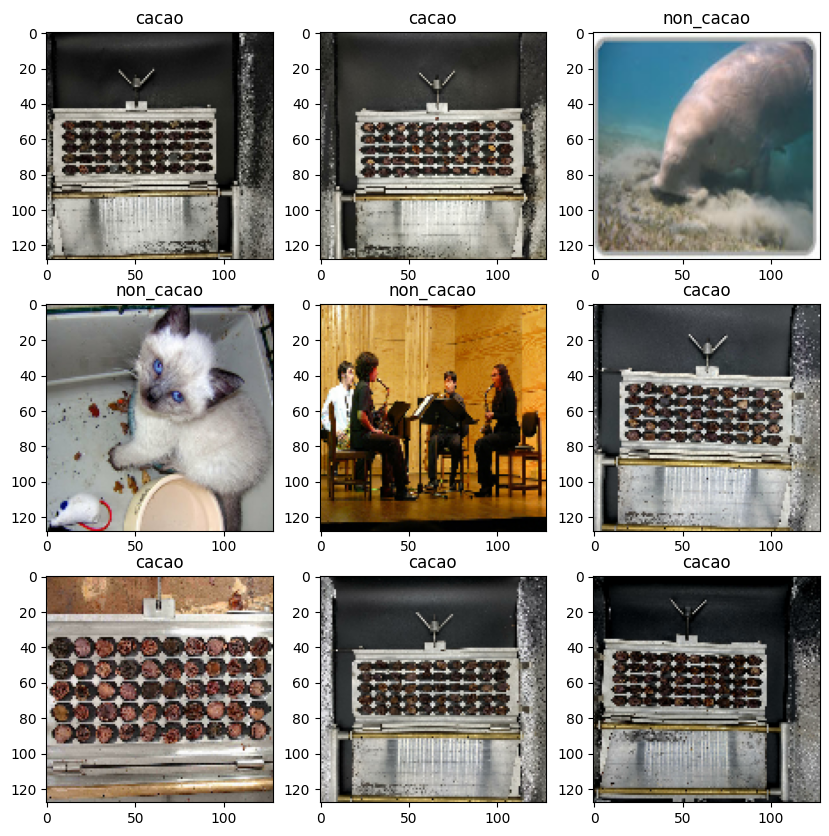

In [19]:
# display images from training set

classNames = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])

In [4]:
## optimize dataset for training performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
all_ds = all_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
b_ds = b_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
## use prebuilt input processing of mobilenet_v2 model architecture
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
INPUT_SHAPE = IMAGE_SIZE + (3,)

# Create the base model from the pre-trained model MobileNetV2

base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",             
    input_shape=INPUT_SHAPE,
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False

# check base model architecture summary
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [27]:
# Create new model on top
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(200, activation="relu"),
     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")                                 
])(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

import os
MODELS_DIR = './models/'
os.makedirs(MODELS_DIR, exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "mobilenetv2/0001"), save_best_only=True)

base_epochs = 10
base_history = model.fit(train_ds, epochs=base_epochs, validation_data=val_ds, 
          callbacks=[checkpoint_cb])

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.0035 - binary_accuracy: 0.9993 - precision_8: 1.0000 - recall_8: 0.9987

INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


44/44 [==============================] - 15s 311ms/step - loss: 0.0035 - binary_accuracy: 0.9993 - precision_8: 1.0000 - recall_8: 0.9987 - val_loss: 5.0658e-12 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 6.5867e-06 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000

INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


44/44 [==============================] - 12s 274ms/step - loss: 6.5867e-06 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 3.4779e-13 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 3/10
44/44 [==============================] - 1s 25ms/step - loss: 6.8507e-08 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 6.5301e-13 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 6.6778e-06 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000

INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


44/44 [==============================] - 28s 653ms/step - loss: 6.6778e-06 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 3.9008e-14 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 5/10
43/44 [============================>.] - ETA: 0s - loss: 5.5386e-05 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000

INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


INFO:tensorflow:Assets written to: ./models/mobilenetv2\0001\assets


44/44 [==============================] - 22s 512ms/step - loss: 5.4101e-05 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 1.7786e-17 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 6/10
44/44 [==============================] - 2s 33ms/step - loss: 6.9158e-06 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 1.2777e-14 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 7/10
44/44 [==============================] - 1s 30ms/step - loss: 2.9513e-10 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 2.9008e-17 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 8/10
44/44 [==============================] - 1s 31ms/step - loss: 1.9840e-10 - binary_accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 2.7149e-17 - val_binary_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.00

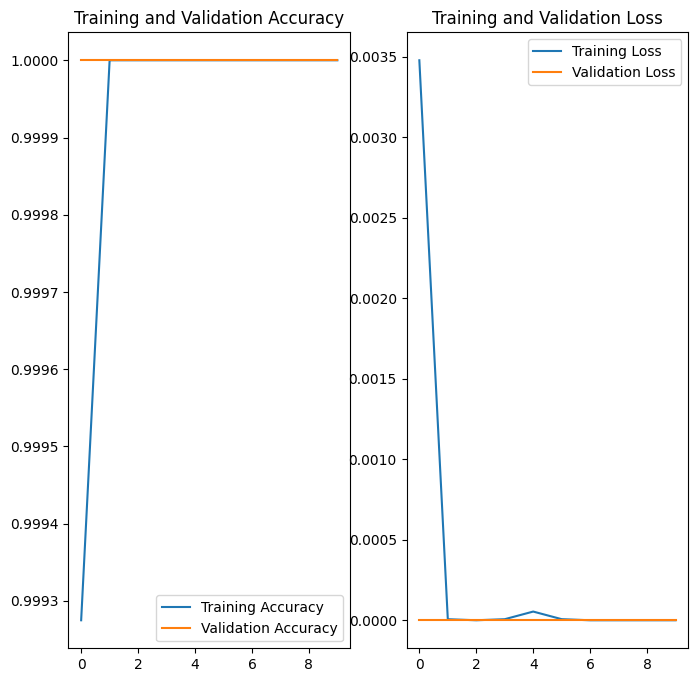

In [30]:
def plot_learning_curves(history, epochs):
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs_range = range(epochs)
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_learning_curves(base_history.history, base_epochs)

In [31]:
def get_y_test_y_pred(model, test_ds):

  y_true = list()
  y_pred = list()

  for x, y in test_ds:
    y_true.append(y)
    y_pred.append((model.predict(x) > 0.5).astype(np.uint32))
  
  y_true = tf.concat(y_true, axis=0)
  y_pred = tf.concat(y_pred, axis=0)

  return y_true, y_pred


# load model that performed best in validation during training
modelnetv2_0001 = tf.keras.models.load_model(os.path.join(
    MODELS_DIR, "mobilenetv2/0001"))
y_test, y_pred = get_y_test_y_pred(modelnetv2_0001, test_ds)

1/1 [==============================] - 0s 19ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00       100

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173



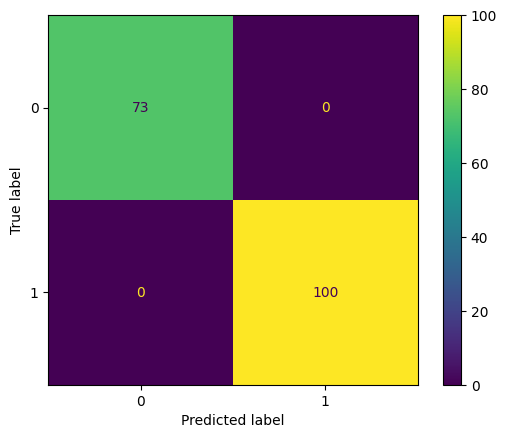

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [33]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# check base model architecture summary
base_model.summary()

Number of layers in the base model:  154
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None,

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  ## lower learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
     metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
)

model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "mobilenetv2/0002"), 
    save_best_only=True)

fine_epochs = 20
fine_history = model.fit(train_ds, epochs=fine_epochs, validation_data=val_ds, 
                         callbacks=[checkpoint_cb])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

INFO:tensorflow:Assets written to: ./models/mobilenetv2\0002\assets


INFO:tensorflow:Assets written to: ./models/mobilenetv2\0002\assets


44/44 [==============================] - 19s 312ms/step - loss: 3.2023e-10 - binary_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 3.0212e-17 - val_binary_accuracy: 1.0000 - val_precision_9: 1.0000 - val_recall_9: 1.0000
Epoch 2/20
44/44 [==============================] - 2s 33ms/step - loss: 3.0501e-09 - binary_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 5.1691e-17 - val_binary_accuracy: 1.0000 - val_precision_9: 1.0000 - val_recall_9: 1.0000
Epoch 3/20
44/44 [==============================] - 1s 33ms/step - loss: 1.2189e-10 - binary_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 5.8361e-17 - val_binary_accuracy: 1.0000 - val_precision_9: 1.0000 - val_recall_9: 1.0000
Epoch 4/20
44/44 [==============================] - 1s 33ms/step - loss: 8.7503e-04 - binary_accuracy: 0.9993 - precision_9: 0.9988 - recall_9: 1.0000 - val_loss: 8.0079e-17 - val_binary_accuracy: 1.0000 - val_precision_9: 1.0000 - val_recall_9: 1.00

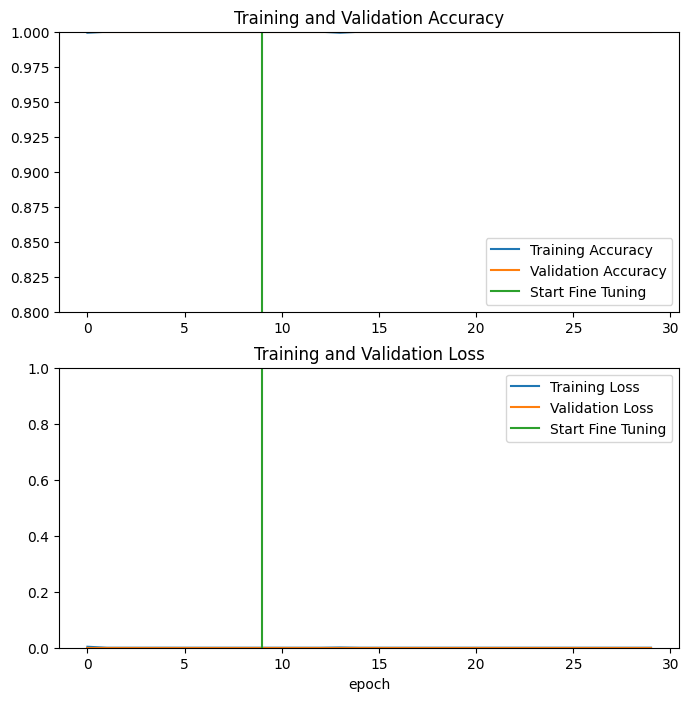

In [35]:
## combine and plot base and fine-tuned model training history

acc = base_history.history["binary_accuracy"] + \
      fine_history.history["binary_accuracy"]
val_acc = base_history.history["val_binary_accuracy"] + \
          fine_history.history["val_binary_accuracy"]
loss = base_history.history["loss"] + fine_history.history["loss"]
val_loss = base_history.history["val_loss"] + fine_history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([base_epochs-1, base_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([base_epochs-1, base_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00       100

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173



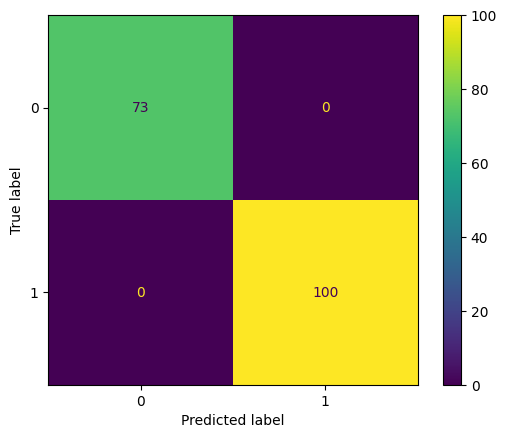

In [36]:
# load model that performed best in validation during training
modelnetv2_0002 = tf.keras.models.load_model(
    os.path.join(MODELS_DIR, "mobilenetv2/0002"))
y_test, y_pred = get_y_test_y_pred(modelnetv2_0002, test_ds)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [11]:
def predict(model, img, threshold=0.5):

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # create a bactch

  raw_prediction = model.predict(img_array)[0][0]
  prediction = 1 if raw_prediction > threshold else 0
  class_name = classNames[prediction]
  confidence = (1 - raw_prediction) * 100 if prediction == 0 else (raw_prediction * 100)

  return class_name, round(confidence, 2)

1/1 [==============================] - 0s 21ms/step


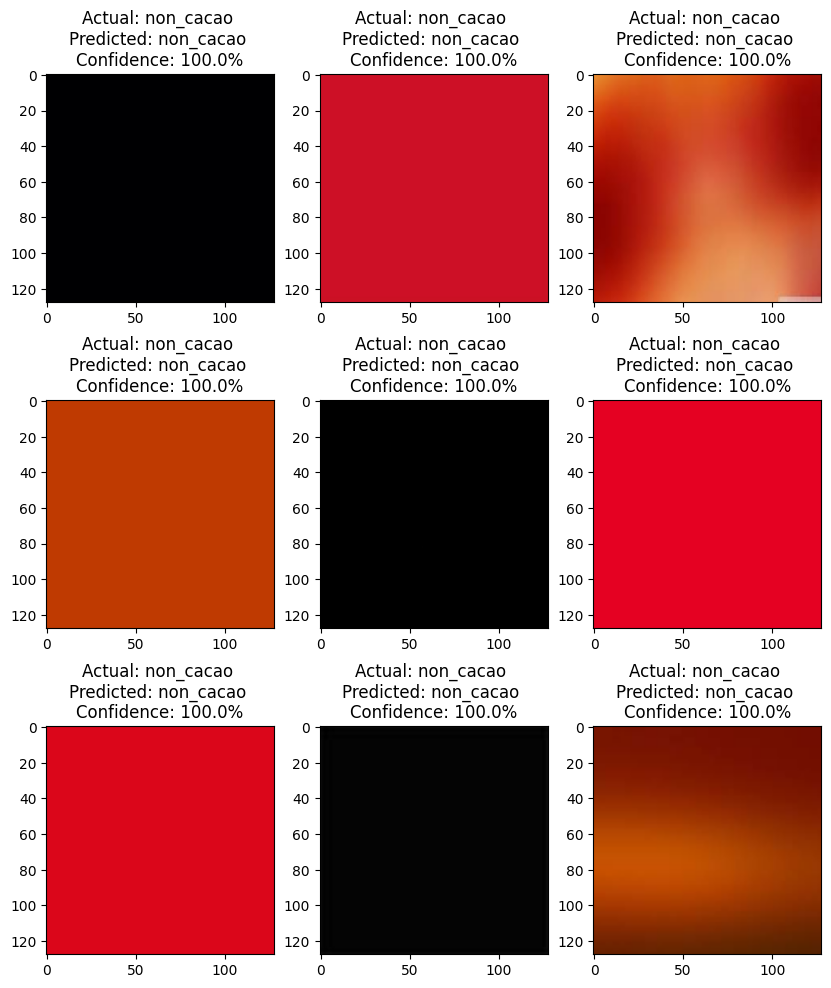

In [54]:
plt.figure(figsize=(10, 12))

for images, labels in b_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_name, confidence  = predict(model, images[i].numpy())
      actual_class = classNames[labels[i]]
      plt.title(f"Actual: {actual_class} \nPredicted: {class_name} \nConfidence: {confidence}%")

1/1 [==============================] - 1s 628ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        17

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



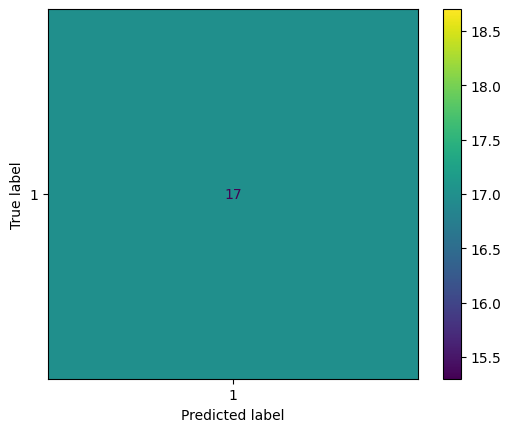

In [53]:
y_test, y_pred = get_y_test_y_pred(modelnetv2_0002, b_ds)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [55]:
## save models to h5 format
modelnetv2_0001.save(os.path.join(MODELS_DIR, "mobilenetv2/mobnet_0001.h5"))
modelnetv2_0002.save(os.path.join(MODELS_DIR, "mobilenetv2/mobnet_0002.h5"))

### Load Model

In [7]:
MODELS_DIR = 'models'
MOBNET_MODEL = os.path.join(MODELS_DIR, 'mobilenetv2', 'mobnet_0002.h5')

m = tf.keras.models.load_model(MOBNET_MODEL)

In [8]:
m.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  ## lower learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
     metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
)

m.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "mobilenetv2/0003"), 
    save_best_only=True)

fine_epochs = 20
fine_history = m.fit(all_ds, epochs=fine_epochs)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [10]:
m.save(os.path.join(MODELS_DIR, 'mobilenetv2', 'mobnet_0003.h5'))

1/1 [==============================] - 0s 15ms/step


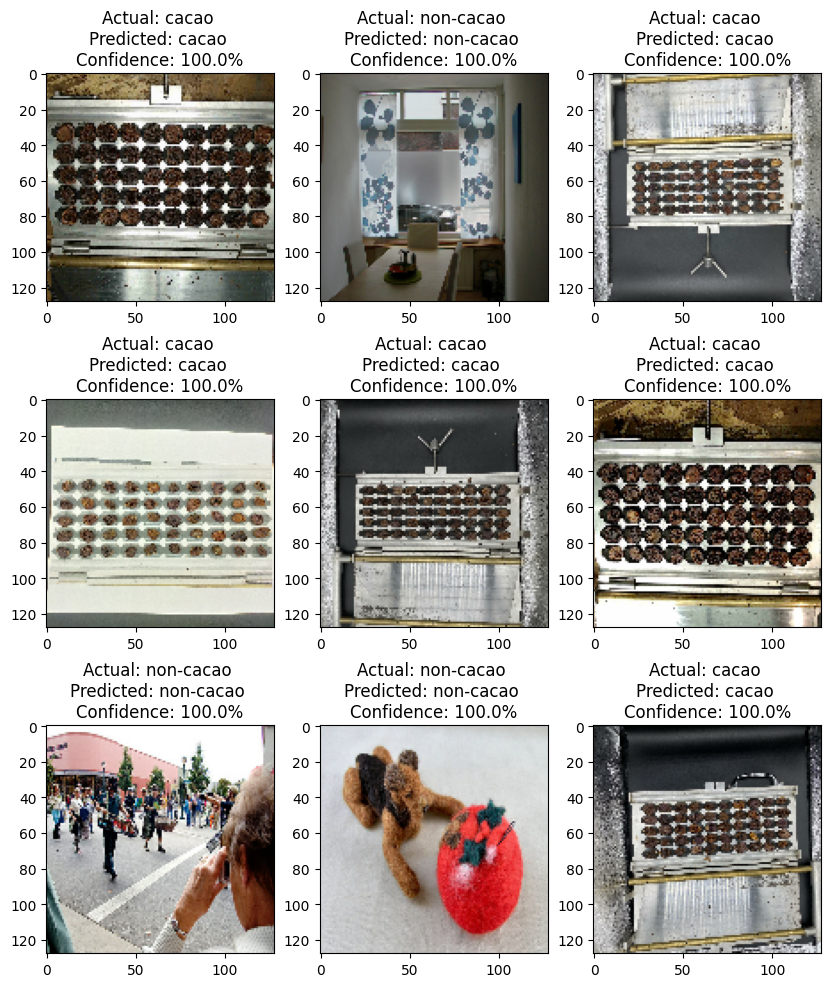

In [22]:
plt.figure(figsize=(10, 12))

classNames = ['cacao', 'non-cacao']

for images, labels in all_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_name, confidence  = predict(m, images[i].numpy())
      actual_class = classNames[labels[i]]
      plt.title(f"Actual: {actual_class} \nPredicted: {class_name} \nConfidence: {confidence}%")